# Setup

In [1]:
import subprocess
import sys

def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = [
    "os", "base64", "requests", "json", "pandas", "python-dotenv", "numpy",
    "seaborn", "scikit-learn", "matplotlib", "xgboost"
]

for package in packages:
    install_and_import(package)

import os
import base64
from requests import post, get
import json
import pandas as pd
from dotenv import load_dotenv
import numpy as np
from functools import cache
import time

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
load_dotenv()
client_id = os.getenv("CLIENT_ID1")
client_secret = os.getenv("CLIENT_SECRET1")
print(client_id)

8ff9af25d5c54f06b14de2a315c01cbd


In [3]:

def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data={
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret,
    }

    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    return json_result['access_token']

def get_token_with_client_credentials(client_id, client_secret):
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data={
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret,
    }

    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    return json_result['access_token']


def get_auth_header(token):
    return {
        "Authorization": "Bearer " + token,
    }


In [4]:
def reset_token(number):
    global client_id, client_secret,token,header
    client_id = os.getenv(f"CLIENT_ID{number}")
    client_secret = os.getenv(f"CLIENT_SECRET{number}")
    token = get_token()
    header = get_auth_header(token)


In [5]:
token = get_token()
header = get_auth_header(token)
print(token)


BQBJRTbF_qcmbL4wv4npskK2mhzgJqKjepoud1OeJHMl-WJxBT707rOY5SCnewUwVxt3GwuK_saLipYs5PWdVM6zG-XTCxjNf307JkSHyiPRLkr68eY


## ALBUM

In [6]:
def get_album(album_id, market=None):
    """
    Get Spotify catalog information for a single album.

    Parameters:
    - album_id (str): The Spotify ID of the album.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.

    Returns:
    - dict: JSON response containing the album's information.
    """
    url = f"https://api.spotify.com/v1/albums/{album_id}"
    headers = header
    params = {}

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_several_albums(album_ids, market=None):
    """
    Get Spotify catalog information for multiple albums identified by their Spotify IDs.

    Parameters:
    - album_ids (list): A list of Spotify IDs for the albums. Maximum: 20 IDs.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.

    Returns:
    - dict: JSON response containing the albums' information.
    """
    url = "https://api.spotify.com/v1/albums"
    headers = header
    params = {
        "ids": ",".join(album_ids)
    }

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_album_tracks(album_id, market=None, limit=20, offset=0):
    """
    Get Spotify catalog information about an album’s tracks.

    Parameters:
    - album_id (str): The Spotify ID of the album.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - limit (int, optional): The maximum number of items to return. Default is 20. Range is 1 to 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the album's tracks information.
    """
    url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

## ARTIST

In [7]:
def get_artist(artist_id):
    """
    Get Spotify catalog information for a single artist.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.

    Returns:
    - dict: JSON response containing the artist's information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}"
    headers = header

    response = get(url, headers=headers)
    return response.json()

def get_several_artists(artist_ids):
    """
    Get Spotify catalog information for several artists based on their Spotify IDs.

    Parameters:
    - artist_ids (list): A list of Spotify IDs for the artists. Maximum: 50 IDs.

    Returns:
    - dict: JSON response containing the artists' information.
    """
    url = "https://api.spotify.com/v1/artists"
    headers = header
    params = {
        "ids": ",".join(artist_ids)
    }

    response = get(url, headers=headers, params=params)
    return response.json()

def get_artist_albums(artist_id, include_groups=None, market=None, limit=20, offset=0):
    """
    Get Spotify catalog information about an artist's albums.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.
    - include_groups (str, optional): A comma-separated list of keywords to filter the response. Valid values are "album", "single", "appears_on", "compilation".
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - limit (int, optional): The maximum number of items to return. Default is 20. Range is 1 to 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the artist's albums information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}/albums"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if include_groups:
        params["include_groups"] = include_groups
    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_artist_top_tracks(artist_id, market=None):
    """
    Get Spotify catalog information about an artist's top tracks by country.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.

    Returns:
    - dict: JSON response containing the artist's top tracks information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks"
    headers = header
    params = {}

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_related_artists(artist_id):
    """
    Get Spotify catalog information about artists similar to a given artist.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.

    Returns:
    - dict: JSON response containing the related artists' information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}/related-artists"
    headers = header

    response = get(url, headers=headers)
    return response.json()

## CATEGORIES

In [8]:
def get_categories(locale=None, limit=20, offset=0):
    """
    Get a list of categories used to tag items in Spotify (on, for example, the Spotify player’s “Browse” tab).

    Parameters:
    - locale (str, optional): The desired language, consisting of an ISO 639-1 language code and an ISO 3166-1 alpha-2 country code, joined by an underscore.
    - limit (int, optional): The maximum number of items to return. Default is 20. Minimum is 1. Maximum is 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the categories information.
    """
    url = "https://api.spotify.com/v1/browse/categories"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if locale:
        params["locale"] = locale

    response = get(url, headers=headers, params=params)
    return response.json()

def get_single_browse_category(category_id, locale=None):
    """
    Get a single category used to tag items in Spotify.

    Parameters:
    - category_id (str): The Spotify category ID for the category.
    - locale (str, optional): The desired language, consisting of an ISO 639-1 language code and an ISO 3166-1 alpha-2 country code, joined by an underscore.

    Returns:
    - dict: JSON response containing the category's information.
    """
    url = f"https://api.spotify.com/v1/browse/categories/{category_id}"
    headers = header
    params = {}

    if locale:
        params["locale"] = locale

    response = get(url, headers=headers, params=params)
    return response.json()

## PLAYLIST

In [9]:

def get_playlist(playlist_id, market=None, fields=None, access_token=None):
    """
    Get a playlist owned by a Spotify user.

    Parameters:
    - playlist_id (str): The Spotify ID of the playlist.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - fields (str, optional): Filters for the query, a comma-separated list of the fields to return.
    - access_token (str, optional): A valid user access token.

    Returns:
    - dict: JSON response containing the playlist information.
    """
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}"
    headers = header
    params = {}

    if market:
        params["market"] = market
    if fields:
        params["fields"] = fields

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        response.raise_for_status()  # Raise an error for bad responses

def get_playlist_items(playlist_id, market=None, fields=None, limit=20, offset=0, additional_types=None):
    """
    Get full details of the items of a playlist owned by a Spotify user.

    Parameters:
    - playlist_id (str): The Spotify ID of the playlist.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - fields (str, optional): Filters for the query.
    - limit (int, optional): The maximum number of items to return. Default is 20. Range is 1 to 50.
    - offset (int, optional): The index of the first item to return. Default is 0.
    - additional_types (str, optional): A comma-separated list of item types that your client supports besides the default track type.

    Returns:
    - dict: JSON response containing the playlist items' information.
    """
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if market:
        params["market"] = market
    if fields:
        params["fields"] = fields
    if additional_types:
        params["additional_types"] = additional_types

    response = get(url, headers=headers, params=params)
    return response.json()

def get_playlist_track_ids(playlist_id, limit=100, offset=0):
    """
    Get only the track IDs from a Spotify playlist.

    Parameters:
    - playlist_id (str): The Spotify ID of the playlist.
    - access_token (str): A valid user access token.
    - limit (int, optional): The maximum number of tracks to return. Default is 100.
    - offset (int, optional): The index of the first track to return. Default is 0.

    Returns:
    - list: A list of track IDs from the playlist.
    """
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = header
    params = {
        "fields": "items(track(id))",
        "limit": limit,
        "offset": offset
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        # Extrair apenas os IDs das faixas
        track_ids = [item['track']['id'] for item in data['items'] if item['track']]
        return track_ids
    else:
        response.raise_for_status()  # Raise an error for bad responses

def get_featured_playlists(locale=None, limit=20, offset=0):
    """
    Get a list of Spotify featured playlists.

    Parameters:
    - locale (str, optional): The desired language, consisting of an ISO 639-1 language code and an ISO 3166-1 alpha-2 country code, joined by an underscore.
    - limit (int, optional): The maximum number of items to return. Default is 20. Minimum is 1. Maximum is 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the featured playlists information.
    """
    url = "https://api.spotify.com/v1/browse/featured-playlists"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if locale:
        params["locale"] = locale

    response = get(url, headers=headers, params=params)
    return response.json()

def get_category_playlists(category_id, limit=20, offset=0):
    """
    Get a list of Spotify playlists tagged with a particular category.

    Parameters:
    - category_id (str): The Spotify category ID for the category.
    - limit (int, optional): The maximum number of items to return. Default is 20. Minimum is 1. Maximum is 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the playlists information.
    """
    url = f"https://api.spotify.com/v1/browse/categories/{category_id}/playlists"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    response = get(url, headers=headers, params=params)
    return response.json()

import requests


## SEARCH

In [10]:
def search_spotify_items(q, types, market=None, limit=20, offset=0, include_external=None):
    """
    Search for Spotify catalog information about albums, artists, playlists, tracks, shows, episodes, or audiobooks.

    Parameters:
    - q (str): The search query.
    - types (list): A list of item types to search across. Allowed values: "album", "artist", "playlist", "track", "show", "episode", "audiobook".
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - limit (int, optional): The maximum number of results to return in each item type. Default is 20. Range is 0 - 50.
    - offset (int, optional): The index of the first result to return. Default is 0. Range is 0 - 1000.
    - include_external (str, optional): If "audio", includes externally hosted audio content as playable.

    Returns:
    - dict: JSON response containing the search results.
    """
    base_url = "https://api.spotify.com/v1/search"
    headers = header
    params = {
        "q": q,
        "type": ",".join(types),
        "limit": limit,
        "offset": offset
    }

    if market:
        params["market"] = market
    if include_external:
        params["include_external"] = include_external

    response = get(base_url, headers=headers, params=params)
    return response.json()

## TRACKS


In [11]:
def get_several_tracks_info(ids, market=None):
    """
    Get detailed Spotify catalog information for multiple tracks based on their Spotify IDs.

    Parameters:
    - ids (list of str): List of Spotify track IDs. Maximum is 50 IDs.
    - market (str, optional): An ISO 3166-1 alpha-2 country code. Only content available in this market will be returned.

    Returns:
    - dict: JSON response containing track information.
    """
    if len(ids) > 100:
        raise ValueError("The maximum number of track IDs is 50.")

    url = "https://api.spotify.com/v1/tracks"
    headers = header
    params = {
        "ids": ",".join(ids)
    }
    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()



@cache
def get_several_tracks_audio_features(ids,token=None):
    """
    Get audio features for multiple tracks based on their Spotify IDs.

    Parameters:
    - ids (list of str): List of Spotify track IDs. Maximum is 100 IDs.

    Returns:
    - dict: JSON response containing the audio features information.
    """
    if len(ids) > 100:
        raise ValueError("The maximum number of track IDs is 100.")

    url = "https://api.spotify.com/v1/audio-features"
    if token is None:
        headers = header
    else:
        headers = get_auth_header(token)
        
    params = {
        "ids": ",".join(ids)
    }

    response = get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()



# Trabalho

### DEFININDO GENEROS

In [259]:
categories = {
    "names": [],
    "ids": []
}

categories_data = get_categories( limit=50, offset=0)['categories']['items']
names = np.array([category['name'] for category in categories_data])
ids = np.array([category['id'] for category in categories_data])

# Efficiently assign lists without a loop
categories["names"] = names.tolist()
categories["ids"] = ids.tolist()
categories

{'names': ['Made For You',
  'New Releases',
  'Marília Mendonça',
  'Brazil',
  'Sertanejo',
  'Pop',
  'Charts',
  'Brazilian Funk',
  'In the car',
  'Hip-Hop',
  'Samba & Pagode',
  'Discover',
  'MPB',
  'AMPLIFIKA',
  'Dance/Electronic',
  'Christian & Gospel',
  'Rock',
  'Indie',
  'RADAR',
  'GLOW',
  'EQUAL',
  'Mood',
  'Workout',
  'Chill',
  'Party',
  'At Home',
  'Sleep',
  'Love',
  'Cooking & Dining',
  'Wellness',
  'Focus',
  'Trending',
  'Decades',
  'Spotify Singles',
  'Cities',
  'Travel',
  'Nature & Noise',
  'Latin',
  'R&B',
  'K-pop',
  'Songwriters',
  'Music + Talk',
  'Fresh Finds',
  'Kids & Family',
  'TV & Movies',
  'Gaming',
  'Anime',
  'Tastemakers',
  'Netflix',
  'Student'],
 'ids': ['0JQ5DAt0tbjZptfcdMSKl3',
  '0JQ5DAqbMKFz6FAsUtgAab',
  '0JQ5DAqbMKFNN285FvRwOf',
  '0JQ5DAqbMKFKGQWi5egawY',
  '0JQ5DAqbMKFJCTDO6ndZMP',
  '0JQ5DAqbMKFEC4WFtoNRpw',
  '0JQ5DAudkNjCgYMM0TZXDw',
  '0JQ5DAqbMKFCkm2Enfbj7Y',
  '0JQ5DAqbMKFIRybaNTYXXy',
  '0JQ5DAqbMKFQ0

In [260]:
filter_categories= ['Sertanejo','Rock','Brazilian Funk','Samba & Pagode','Dance/Electronic','Christian & Gospel','Indie','Chill']

In [261]:

categories_df = pd.DataFrame(categories)
categories_df = categories_df[categories_df['names'].isin(filter_categories)]
categories_df = categories_df.reset_index(drop=True)
categories_df.head()

,names,ids
0,Sertanejo,0JQ5DAqbMKFJCTDO6ndZMP
1,Brazilian Funk,0JQ5DAqbMKFCkm2Enfbj7Y
2,Samba & Pagode,0JQ5DAqbMKFARvdmw6EIef
3,Dance/Electronic,0JQ5DAqbMKFHOzuVTgTizF
4,Christian & Gospel,0JQ5DAqbMKFy0OenPG51Av


### Buscando playlist


In [262]:
import concurrent.futures

# Inicializando o dicionário
playlists = {
    "ids": [],
    "messages": [],
}

# Função auxiliar para extrair IDs e mensagens
def extract_ids_and_messages(track_collection):
    items = track_collection['playlists']['items']
    message = track_collection['message']
    return [(item['id'], message) for item in items]

# Executando a função de forma concorrente
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Obtém as playlists para cada categoria em threads
    playlists_data = list(executor.map(lambda item: get_category_playlists(item, limit=50, offset=0), categories_df['ids']))
    
    # Extrai os dados de cada playlist de forma concorrente
    extracted_data = list(executor.map(extract_ids_and_messages, playlists_data))

# Adicionando IDs e mensagens ao dicionário
for data in extracted_data:
    for playlist_id, message in data:
        playlists["ids"].append(playlist_id)
        playlists["messages"].append(message)


In [263]:
playlists_df=pd.DataFrame(playlists)
playlists_df

,ids,messages
0,37i9dQZF1DXdSjVZQzv2tl,Sertanejo
1,37i9dQZF1DX5lAV5ZGu9ik,Sertanejo
2,37i9dQZF1DXc5EXfkDXlmk,Sertanejo
3,37i9dQZF1DX3R59Eoqqsy8,Sertanejo
4,37i9dQZF1DXcC14V9ZdJ9I,Sertanejo
...,...,...
293,37i9dQZF1DWWQRwui0ExPn,Chill
294,37i9dQZF1DX8V4BE7YIpvE,Chill
295,37i9dQZF1DXdLK5wjKyhVm,Chill
296,37i9dQZF1DWVrtsSlLKzro,Chill


In [264]:
def list_value_counts_less_than(playlists_df, num=50):
    value_counts = playlists_df.value_counts()
    messages_less_than = value_counts[value_counts < num]
    return messages_less_than

def list_value_counts_more_than(playlists_df, num=50):
    value_counts = playlists_df.value_counts()
    messages_more_than = value_counts[value_counts > num]
    return messages_more_than

In [265]:
#exibe as messages que tem menos de 50 playlists message value counts
messages_less_than_50 =list_value_counts_less_than(playlists_df['messages'],50)
len(messages_less_than_50)

6

In [266]:
to_50 = {
    "ids": [],
    "number_to_50": [],
}

for item in messages_less_than_50.index:
    category_id = categories_df.loc[categories_df['names'] == item, 'ids'].values[0]
    number_to_50=50-messages_less_than_50[item]
    to_50["ids"].append(category_id)
    to_50["number_to_50"].append(number_to_50)

    

In [267]:
from concurrent.futures import ThreadPoolExecutor

def fetch_playlists(item, limit, offset):
    return get_category_playlists(item, limit=limit, offset=offset)

def extract_data(data):
    return extract_ids_and_messages(data)

playlists_data = []
extracted_data = []

with ThreadPoolExecutor() as executor:
    for i in [1, 2, 3]:
        # Obtém as playlists para cada categoria
        playlists_data.extend(executor.map(fetch_playlists, to_50['ids'], [to_50['number_to_50']] * len(to_50['ids']), [i] * len(to_50['ids'])))
    
    # Extrai os dados de cada playlist
    extracted_data.extend(executor.map(extract_data, playlists_data))

# Adicionando IDs e mensagens ao dicionário
for data in extracted_data:
    for playlist_id, message in data:
        playlists["ids"].append(playlist_id)
        playlists["messages"].append(message)

In [268]:

playlists_df=pd.DataFrame(playlists)
playlists_df.messages.value_counts()


messages
Samba & Pagode        70
Chill                 67
Brazilian Funk        64
Sertanejo             64
Indie                 60
Dance/Electronic      53
Rock                  50
Christian & Gospel    50
Name: count, dtype: int64

In [269]:
#remove todas as linhas em que value counts message for menor que 40

messages_less_than_40 = list_value_counts_less_than(playlists_df['messages'],40)
#remove todas as messages de playlists_df que estiverem em messages_less_than_40
playlists_df = playlists_df[~playlists_df['messages'].isin(messages_less_than_40.index)]

In [270]:
more_than_50 = list_value_counts_more_than(playlists_df['messages'],50)
more_than_50

# Function to remove excess rows
def remove_excess_rows(df, message, excess_count):
    indices_to_remove = df[df['messages'] == message].index[:excess_count]
    return df.drop(indices_to_remove)

# Remove excess rows for each message
for message, count in more_than_50.items():
    excess_count = count - 50
    playlists_df = remove_excess_rows(playlists_df, message, excess_count)

# Reset index after removal
playlists_df = playlists_df.reset_index(drop=True)

In [271]:
playlists_df

,ids,messages
0,37i9dQZF1DX7IK76Iw6baR,Sertanejo
1,37i9dQZF1DWXeSNtpjKSsO,Sertanejo
2,37i9dQZF1DX3R59Eoqqsy8,Sertanejo
3,37i9dQZF1DZ06evO1LJ7ge,Sertanejo
4,37i9dQZF1DZ06evO3SFpRU,Sertanejo
...,...,...
395,37i9dQZF1DXaXB8fQg7xif,Dance/Electronic
396,37i9dQZF1DXd14ByHZraz1,Dance/Electronic
397,37i9dQZF1DXa71eg5j9dKZ,Dance/Electronic
398,37i9dQZF1DX3Kdv0IChEm9,Dance/Electronic


In [272]:
playlists_df.messages.value_counts()

messages
Sertanejo             50
Brazilian Funk        50
Samba & Pagode        50
Dance/Electronic      50
Christian & Gospel    50
Rock                  50
Indie                 50
Chill                 50
Name: count, dtype: int64

In [273]:
playlists_ids = playlists_df['ids'].tolist()

In [274]:
playlists_ids

['37i9dQZF1DX7IK76Iw6baR',
 '37i9dQZF1DWXeSNtpjKSsO',
 '37i9dQZF1DX3R59Eoqqsy8',
 '37i9dQZF1DZ06evO1LJ7ge',
 '37i9dQZF1DZ06evO3SFpRU',
 '37i9dQZF1DZ06evO0Fj4S8',
 '37i9dQZF1DZ06evO0bAR06',
 '37i9dQZF1DZ06evO2zhM2G',
 '37i9dQZF1DZ06evO4qoMev',
 '37i9dQZF1DZ06evO1oNsHf',
 '37i9dQZF1DXcC14V9ZdJ9I',
 '37i9dQZF1DXc5EXfkDXlmk',
 '37i9dQZF1DZ06evO1vscg0',
 '37i9dQZF1DZ06evO31EP3a',
 '37i9dQZF1DZ06evO1h0zXZ',
 '37i9dQZF1DZ06evO452uOc',
 '37i9dQZF1DZ06evO07kRCE',
 '37i9dQZF1DZ06evO31xZp5',
 '37i9dQZF1DZ06evO0esd9M',
 '37i9dQZF1DZ06evO3MVkh6',
 '37i9dQZF1DX9We8dK817NX',
 '37i9dQZF1DWVPifjQJoRjt',
 '37i9dQZF1DX6c9yVebnzyY',
 '37i9dQZF1DWTdN26VziZZM',
 '37i9dQZF1DX2mPnuv6Mm80',
 '37i9dQZF1DWYzunN6t07GD',
 '37i9dQZF1DWW6EwN6CPxGO',
 '37i9dQZF1DX9We8dK817NX',
 '37i9dQZF1DX2mPnuv6Mm80',
 '37i9dQZF1DWZgZxLup5qYy',
 '37i9dQZF1DX4MdXmAY6EDq',
 '37i9dQZF1DWTSW6EnevZMi',
 '37i9dQZF1DWTzoMWoVzs9W',
 '37i9dQZF1DZ06evO07uQHn',
 '37i9dQZF1DZ06evO0xCniH',
 '37i9dQZF1DZ06evO3psVe8',
 '37i9dQZF1DZ06evO040C69',
 

## Spotpy


In [275]:
len(playlists_ids)

400

In [276]:
def get_tracks_ids (info):
    track_ids = []
    for info_item in info:
        if info_item['tracks'] and info_item['tracks']['items']:
            for item in info_item['tracks']['items']:
                if item and item['track']:
                    track_ids.append(item['track']['id'])
    return track_ids

In [277]:
def get_playlist_info(playlists_df):
    playlist_info = {
        "ids": [],
        "message": [],
    }
    playlists_ids = playlists_df['ids'].tolist()
    messages = playlists_df['messages'].tolist()
    
    for idx, playlist_id in enumerate(playlists_ids):
        response=get_playlist_track_ids(playlist_id)
        
        playlist_info["ids"].extend(response)  # Adiciona todos os IDs de uma vez
        playlist_info["message"].extend([messages[idx]] * len(response))  # Repete a mensagem para cada item em response
        
    return playlist_info


In [282]:

def get_playlist_info(playlists_df):
    playlist_info = {
        "ids": [],
        "message": [],
    }
    playlists_ids = playlists_df['ids'].tolist()
    messages = playlists_df['messages'].tolist()

    for idx in range(len(playlists_ids)):
        playlist_id = playlists_ids[idx]
        for number in range(11):  # Try numbers from 0 to 10
            try:
                response = get_playlist_track_ids(playlist_id)
                playlist_info["ids"].extend(response)
                playlist_info["message"].extend([messages[idx]] * len(response))
                break
            except Exception:
                reset_token(number)
        else:
            # If all retries fail, add empty response
            playlist_info["ids"].extend([])
            playlist_info["message"].extend([messages[idx]] * 0)

    return playlist_info


In [284]:

def get_playlist_info(playlists_df):
    playlist_info = {
        "ids": [],
        "message": [],
    }
    playlists_ids = playlists_df['ids'].tolist()
    messages = playlists_df['messages'].tolist()

    def fetch_playlist_data(idx):
        playlist_id = playlists_ids[idx]
        for number in range(11):  # Try numbers from 0 to 10
            try:
                response = get_playlist_track_ids(playlist_id)
                return response, messages[idx]
            except Exception:
                reset_token(number)
        # If all retries fail, return [], messages[idx]
        return [], messages[idx]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch_playlist_data, range(len(playlists_ids))))

    for response, message in results:
        playlist_info["ids"].extend(response)
        playlist_info["message"].extend([message] * len(response))

    return playlist_info

In [392]:
import os

if not os.path.exists('track_ids.csv'):
    print("Arquivo track_ids.csv não existe.Obtendo informacoes.")
    playlist_info = get_playlist_info(playlists_df)
    track_ids_df=pd.DataFrame(playlist_info)
    track_ids_df.to_csv('track_ids.csv', index=False)
else:
    print("Arquivo track_ids.csv já existe.")
    track_ids_df = pd.read_csv('track_ids.csv')
    #dropa linhas que nao estao em playlists_df
    track_ids_df = track_ids_df[track_ids_df['message'].isin(playlists_df['messages'])]
    track_ids_df = track_ids_df.reset_index(drop=True)


Arquivo track_ids.csv já existe.


In [393]:
track_ids_df.message.value_counts()

message
Chill                 4650
Christian & Gospel    3759
Dance/Electronic      3703
Samba & Pagode        3674
Rock                  3300
Indie                 3174
Brazilian Funk        2802
Sertanejo             2636
Name: count, dtype: int64

In [395]:
#inverter a ordem dos de message com ids
track_ids_df = track_ids_df[['message', 'ids']]
track_ids_df

,message,ids
0,Sertanejo,5rHhO6SBSzo3E9m3KHyCtt
1,Sertanejo,7pkpWcko6KEZANj0xKsCsu
2,Sertanejo,1wubETHu3SeJHfbz9itEH0
3,Sertanejo,7l9Tq5phzkLnhWUyfp702G
4,Sertanejo,7f1tZNtc1t456ybBsl5sfK
...,...,...
27693,Dance/Electronic,6wGJqxCSM2Ooo3171l1uch
27694,Dance/Electronic,7hSTXrC5oAMss4LTPbbkua
27695,Dance/Electronic,4tKiLOHkzrY43buY7hd7ic
27696,Dance/Electronic,6T5rBm4nZNB1f19d4uOGwR


In [396]:
track_ids_df.ids.value_counts()

ids
664sTugsU30HsYEwGfmv0C    19
5u7Xi0QhfkYy3qETJJ5lae    18
7hhyEKCjqPioAuQBmBZDnr    18
3ZNjlT5zR0jkEVzSSZCQeJ    17
4WXVqLSRHF4ypdiBngbcqU    15
                          ..
1OM5jg270V0MJAWViprzUf     1
38c1BU0m7WR2Ez8zUqQI9y     1
597JMOaqGsplMsinzKHvfa     1
3KfDSBOaumGB0Oqzcz9ora     1
5sB6nWsUKo40L5AeJ7Ja7Q     1
Name: count, Length: 14837, dtype: int64

In [397]:
#mostra quais ids tem mais de 1 category e quais sao elas
duplicated_ids=track_ids_df[track_ids_df['ids'].duplicated(keep=False)].sort_values('ids').reset_index(drop=True)
duplicated_ids

,message,ids
0,Samba & Pagode,008KWijTsFnZRK3E7oGNxl
1,Samba & Pagode,008KWijTsFnZRK3E7oGNxl
2,Samba & Pagode,008KWijTsFnZRK3E7oGNxl
3,Samba & Pagode,008KWijTsFnZRK3E7oGNxl
4,Dance/Electronic,00E0Z2jrF7reoHps4zcbWQ
...,...,...
18342,Indie,7zkDEBSxkcBVsStS4qBFpK
18343,Brazilian Funk,7zmXrVvVhmsbdYbpVCQpEp
18344,Brazilian Funk,7zmXrVvVhmsbdYbpVCQpEp
18345,Chill,7znB7bwyQiJFQA0xjYJCqt


In [398]:
# Agrupar por 'ids' e obter categorias únicas
grouped = duplicated_ids.groupby('ids')['message'].unique()

# Filtrar para ids com mais de uma categoria
multiple_categories = grouped[grouped.apply(len) > 1]

In [399]:
multiple_categories_df = multiple_categories.reset_index()
multiple_categories_df = multiple_categories_df.drop(columns='message')

In [400]:
#remove ids presente em multiple_categories_df
track_ids_df = track_ids_df[~track_ids_df['ids'].isin(multiple_categories_df['ids'])]

In [401]:
#remove ids duplicados e nulos e reseta o index
track_ids_df = track_ids_df.drop_duplicates(subset=['ids']).dropna().reset_index(drop=True)
track_ids_df

,message,ids
0,Sertanejo,5rHhO6SBSzo3E9m3KHyCtt
1,Sertanejo,7pkpWcko6KEZANj0xKsCsu
2,Sertanejo,1wubETHu3SeJHfbz9itEH0
3,Sertanejo,7l9Tq5phzkLnhWUyfp702G
4,Sertanejo,7f1tZNtc1t456ybBsl5sfK
...,...,...
14461,Dance/Electronic,4cjxlrzzn8hSMEfRzJypFg
14462,Dance/Electronic,0FCUZdyI2UvVscNAnKHopR
14463,Dance/Electronic,0LAXSNjh2UVHxDfJEvnUtS
14464,Dance/Electronic,4wSMi5urWxpBPbnWqfI1Ht


In [402]:
track_ids_df = track_ids_df[track_ids_df['message'].isin(filter_categories)]
#reset index
track_ids_df = track_ids_df.reset_index(drop=True)
track_ids_df


,message,ids
0,Sertanejo,5rHhO6SBSzo3E9m3KHyCtt
1,Sertanejo,7pkpWcko6KEZANj0xKsCsu
2,Sertanejo,1wubETHu3SeJHfbz9itEH0
3,Sertanejo,7l9Tq5phzkLnhWUyfp702G
4,Sertanejo,7f1tZNtc1t456ybBsl5sfK
...,...,...
14461,Dance/Electronic,4cjxlrzzn8hSMEfRzJypFg
14462,Dance/Electronic,0FCUZdyI2UvVscNAnKHopR
14463,Dance/Electronic,0LAXSNjh2UVHxDfJEvnUtS
14464,Dance/Electronic,4wSMi5urWxpBPbnWqfI1Ht


In [403]:
track_ids_df.message.unique()

array(['Sertanejo', 'Brazilian Funk', 'Samba & Pagode',
       'Christian & Gospel', 'Rock', 'Indie', 'Chill', 'Dance/Electronic'],
      dtype=object)

In [407]:
track_ids_df.message.value_counts().mean()

np.float64(1808.25)

In [ ]:
# Get the minimum count of messages
min_count = track_ids_df.message.value_counts().min()

# Sample the dataframe to ensure each message has the same number of entries
balanced_track_ids_df = track_ids_df.groupby('message').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
balanced_track_ids_df.message.value_counts()

/tmp/ipykernel_5566/729407180.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_track_ids_df = track_ids_df.groupby('message').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


,message,ids
0,Sertanejo,5rHhO6SBSzo3E9m3KHyCtt
1,Sertanejo,7pkpWcko6KEZANj0xKsCsu
2,Sertanejo,1wubETHu3SeJHfbz9itEH0
3,Sertanejo,7l9Tq5phzkLnhWUyfp702G
4,Sertanejo,7f1tZNtc1t456ybBsl5sfK
...,...,...
14461,Dance/Electronic,4cjxlrzzn8hSMEfRzJypFg
14462,Dance/Electronic,0FCUZdyI2UvVscNAnKHopR
14463,Dance/Electronic,0LAXSNjh2UVHxDfJEvnUtS
14464,Dance/Electronic,4wSMi5urWxpBPbnWqfI1Ht


In [414]:
balanced_track_ids_df.value_counts()

message         ids                   
Sertanejo       7jkyDOsDUbjJEsgkADKe5a    1
                7jyCpy6CXAdVWuAtulhRsp    1
                7k2QCPE2kNo07cvaE6VsDw    1
                7kJYocF0sLDtc4wQaMSVTg    1
                7l9Tq5phzkLnhWUyfp702G    1
                                         ..
Brazilian Funk  02I0Nm97YdmZ8teGFcIHEy    1
                02r5jq3Rb3gfWAm2kHcx48    1
                04kc5SEMpaNQXzZakiAOUv    1
                04vzhKfl5HtPEgrdZJCZ7L    1
                058t1LUDIQuWs44iagnUlO    1
Name: count, Length: 8960, dtype: int64

In [416]:


def group_ids_by_message_to_df(df):
    rows = []
    for message, group in df.groupby('message'):
        ids = group['ids'].tolist()
        for i in range(0, len(ids), 50):
            rows.append({'message': message, 'track_ids': ids[i:i+50]})
    return pd.DataFrame(rows)

# Chamada da função
track_ids_df_filled = group_ids_by_message_to_df(balanced_track_ids_df)

# Exibir o resultado
track_ids_df_filled


,message,track_ids
0,Brazilian Funk,"[10BAfuVOPB5C1ed1ZQCfkq, 0qFIyni8ve8T2RHSLuuWR..."
1,Brazilian Funk,"[1TdMqn7bZAi75dJLtPvb2j, 4nnm4rDNcedlJ1K8Hz5JK..."
2,Brazilian Funk,"[2qoaNqa0bBF99kAdJdM7oV, 5mmSl45GHuLyQZBM5jRa0..."
3,Brazilian Funk,"[5J1xChbEwiI3q371r7mDOg, 0ZWNQi6wgNjKFcQx6QuLm..."
4,Brazilian Funk,"[5Wo7n1OpPGKSMzTvfou9s8, 2WrtsbhODhBgGEDyEYIyS..."
...,...,...
179,Sertanejo,"[6HTmn2dm2OKBPNtgMyb986, 2MXmqNtmr0yywE7vZhYBX..."
180,Sertanejo,"[0HDMisLsuGNml98Xq7atpm, 7BLf2w4tV2dBlE8QQ5Zju..."
181,Sertanejo,"[2yhl5Jg6UXoUUExsi5kc0N, 4xAGuRRKOgoaZbMGdmTD3..."
182,Sertanejo,"[7EAkUVnalwN4Fc6BhgSkgp, 0TFDZ8x550p3jx656KgVd..."


In [417]:
len(track_ids_df_filled['message'].unique())==len(track_ids_df['message'].unique())

True

In [418]:
#mudar o nome de ids para track_ids
track_ids_df_filled = track_ids_df_filled.rename(columns={'ids': 'track_ids'})

In [419]:
for i, ids in enumerate(track_ids_df_filled.track_ids):
    if len(ids)>50:
        track_ids = track_ids_df_filled['track_ids'][i]
        print(f"Ids: {",".join(track_ids)} Tamanho: {len(track_ids)} Erro no Index: {i} ")

In [420]:

track_ids = track_ids_df_filled['track_ids'][0]
print(len(track_ids),",".join(track_ids))

50 10BAfuVOPB5C1ed1ZQCfkq,0qFIyni8ve8T2RHSLuuWRt,1DMQauE1EjmfysCJGUyxB1,0C1cJj3ZNCS75sojrcMhZV,2kWowyDGD9yOL0WQzni20m,2329XxRFYoAPdQSb4DmjXQ,661V9NaDn7fquFxjaErO1K,3Bn7ZKy6b9tVldjCE0TQdE,62W2f0QOg20ufNjJQHqnkq,6xtAx60ZIXljN69hSK3Sjn,1RQftOpZQKRPj3G8o0AfAZ,5o92tAnQscQmAUsmbFcQCD,2azJDduVngaqpaUsxKXevt,2eIunps37syHz20NuT7oXx,1VPnjkHQWS30d9QXDBfJUJ,2OU6RxOSA8n7nDpg3gF3aX,4PJFpx2kCWwd1bCiU3SJ2u,06WzOusi75IJ2Ew8fnRjHd,0Fykt5fBBZGG1U4DOgpA77,7A0ZHoT5x6DHACj8Dpnz13,1eAVHUuwym6CFpN9xTUl1c,4XyqXcevqEFMmM7JfPrct5,4VqtUzguJZRomDHACkvwig,2WIf44OMuVA5NTIQ6JSl0d,3ibRxEv4KkcU9e259eyNJA,1DsMpqkOqDocqccS7DLWxu,0XkH47qUbNA4YGdD4WEjAA,7DROtyR6IMNifyZmyksyE7,6UmDguW3cTi31W3JPSto1a,4WrKUo5uQO4XuNmTUXzzrv,33FvPiWyx1sonHNl5ltl1U,4W87Hv4pBFsE0JEi7enRBQ,2EaGXjPPV1rcKHwQDKcZC7,5GV7OpSEb8MPTryL0Q5i6c,3AbNNvo2OmyeDMvRBgf9vk,3JTuZvqu7bWkQj1oDDM9AQ,4fWB8tJgwtMUkgOHEMTMRE,4koUrXFuoId1b6wrMF3laS,6zKiQx3axCsAxigtzWfyeK,0YqTL3nSL36OFdHwHoqCag,4PDw1XpsurgUnN7YSZmh1Q,2wXqRqVGiGB2fyy9eoPJbP,5nCU2l9qq9dYPgkASU8Lgo,5lZQrRhE

In [442]:
track_features_response = get_several_tracks_audio_features(tuple(track_ids_df_filled['track_ids'][0][:3]))
track_features_response

{'audio_features': [{'danceability': 0.701,
   'energy': 0.556,
   'key': 6,
   'loudness': -6.069,
   'mode': 0,
   'speechiness': 0.273,
   'acousticness': 0.176,
   'instrumentalness': 0,
   'liveness': 0.0555,
   'valence': 0.72,
   'tempo': 92.509,
   'type': 'audio_features',
   'id': '10BAfuVOPB5C1ed1ZQCfkq',
   'uri': 'spotify:track:10BAfuVOPB5C1ed1ZQCfkq',
   'track_href': 'https://api.spotify.com/v1/tracks/10BAfuVOPB5C1ed1ZQCfkq',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/10BAfuVOPB5C1ed1ZQCfkq',
   'duration_ms': 190968,
   'time_signature': 4},
  {'danceability': 0.591,
   'energy': 0.407,
   'key': 11,
   'loudness': -8.555,
   'mode': 0,
   'speechiness': 0.0646,
   'acousticness': 0.73,
   'instrumentalness': 0.000163,
   'liveness': 0.112,
   'valence': 0.0903,
   'tempo': 79.894,
   'type': 'audio_features',
   'id': '0qFIyni8ve8T2RHSLuuWRt',
   'uri': 'spotify:track:0qFIyni8ve8T2RHSLuuWRt',
   'track_href': 'https://api.spotify.com/v1/tracks/0qFIyn

In [424]:
track_features_response["audio_features"][2]['danceability']

0.848

In [463]:
reset_token(5)


In [ ]:
# Inicializa o dicionário para armazenar as características das faixas
track_features = {
    "danceability": [],
    "energy": [],
    "key": [],
    "loudness": [],
    "mode": [],
    "speechiness": [],
    "acousticness": [],
    "instrumentalness": [],
    "liveness": [],
    "valence": [],
    "tempo": [],
    "duration_ms": [],
    "time_signature": [],
    "category": []
}

# Função auxiliar para processar uma linha do DataFrame

def process_track_features(index):
    try:
        features = get_several_tracks_audio_features(tuple(track_ids_df_filled['track_ids'][index]))
        
        if 'audio_features' not in features:
            for i in range(11):
                print(f"Audio features not found for index {index}.")
                reset_token(i)
                time.sleep(30)
                features = get_several_tracks_audio_features(tuple(track_ids_df_filled['track_ids'][index]))
                print(f"api key {i}")
            if 'audio_features' not in features:
                raise Exception(f"Audio features not found for index {index}.")
                
        
        row_features = {k: [] for k in track_features}
        
        for idx , track in enumerate(features['audio_features']):
            row_features["danceability"].append(track["danceability"])
            row_features["energy"].append(track["energy"])
            row_features["key"].append(track["key"])
            row_features["loudness"].append(track["loudness"])
            row_features["mode"].append(track["mode"])
            row_features["speechiness"].append(track["speechiness"])
            row_features["acousticness"].append(track["acousticness"])
            row_features["instrumentalness"].append(track["instrumentalness"])
            row_features["liveness"].append(track["liveness"])
            row_features["valence"].append(track["valence"])
            row_features["tempo"].append(track["tempo"])
            row_features["duration_ms"].append(track["duration_ms"])
            row_features["time_signature"].append(track["time_signature"]) 
            row_features["category"].append(track_ids_df_filled['message'][index])
        
        return row_features
    
    except Exception as e:
        print(f"Error processing track features for index {index}[{idx}]: {e}")
        return {k: [] for k in track_features}  # Retorna uma linha vazia em caso de erro

# Processa cada linha de forma sequencial (single-threaded)
def get_tracks_features(track_ids_df_filled,initial_index=0):
    print(f"Initial index: {initial_index}")
    for index in range(len(track_ids_df_filled.track_ids[initial_index:])):
        result = process_track_features(index)
        time.sleep(10)
        for key in track_features:
            track_features[key].extend(result[key])
    return track_features


## Pegando o DF

In [12]:
if not os.path.exists('track_features.csv'):
    track_features=get_tracks_features(track_ids_df_filled,initial_index=44)
    df_track_features = pd.DataFrame(track_features)
    df=df_track_features
    df.to_csv('track_features.csv', index=False)

else:
    print("Arquivo df_track_features.csv já existe.")
    df = pd.read_csv('track_features.csv')
    df = df.dropna()
    df = df.reset_index(drop=True)


Arquivo df_track_features.csv já existe.


In [13]:
df.category.value_counts()

category
Brazilian Funk        2240
Chill                 2170
Dance/Electronic      1120
Rock                  1120
Indie                 1120
Christian & Gospel     970
Samba & Pagode         100
Name: count, dtype: int64

In [14]:
df=df[df['category']!="Samba & Pagode"]
df=df[df['category']!="Indie"]

In [15]:
#dropa aleatoriamente metade de Chill
df_chill = df[df['category']=="Chill"]
df_chill = df_chill.sample(frac=0.5, random_state=42)
df = df.drop(df_chill.index)
#dropa aleatoriamente de Brazilian Funk
df_brazilian_funk = df[df['category']=="Brazilian Funk"]
df_brazilian_funk = df_brazilian_funk.sample(frac=0.5, random_state=42)
df = df.drop(df_brazilian_funk.index)

In [16]:
df.category.value_counts()

category
Brazilian Funk        1120
Rock                  1120
Dance/Electronic      1120
Chill                 1085
Christian & Gospel     970
Name: count, dtype: int64

In [17]:
#drop time_signature
df=df.drop(columns=['time_signature'])

In [18]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,category
0,0.701,0.556,6,-6.069,0,0.2730,0.176,0.000000,0.0555,0.7200,92.509,190968,Brazilian Funk
1,0.591,0.407,11,-8.555,0,0.0646,0.730,0.000163,0.1120,0.0903,79.894,228000,Brazilian Funk
3,0.889,0.821,8,-2.415,1,0.1840,0.265,0.000000,0.0949,0.7320,90.014,573334,Brazilian Funk
4,0.802,0.520,0,-6.973,1,0.2530,0.447,0.000000,0.0942,0.9560,160.054,162046,Brazilian Funk
5,0.715,0.411,8,-8.585,1,0.3090,0.162,0.000000,0.1040,0.5850,82.452,279000,Brazilian Funk


# test

In [32]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


X = df.drop("category", axis=1)
y = df["category"]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size= 0.2, 
                                       random_state=42, shuffle = True)

col = xtrain.columns
scalerx = MinMaxScaler()

xtrain = scalerx.fit_transform(xtrain)
xtest = scalerx.transform(xtest)

xtrain = pd.DataFrame(xtrain, columns = col)
xtest = pd.DataFrame(xtest, columns = col)
le = preprocessing.LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

x = pd.concat([xtrain, xtest], axis = 0)
y = pd.concat([pd.DataFrame(ytrain), pd.DataFrame(ytest)], axis = 0)

y_train = le.inverse_transform(ytrain)
y_test = le.inverse_transform(ytest)
y_org = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)], axis = 0)

In [14]:
%pip install tensorflow

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import Isomap, TSNE, MDS
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import warnings 

Note: you may need to restart the kernel to use updated packages.


In [33]:
early_stopping1 = keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                               patience = 10, restore_best_weights = True)
early_stopping2 = keras.callbacks.EarlyStopping(monitor = "val_accuracy", 
                                               patience = 10, restore_best_weights = True)

model = keras.Sequential([
    keras.layers.Input(name = "input", shape = (xtrain.shape[1],)),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(max(ytrain)+1, activation = "softmax")
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,853 (245.52 KB)

 Trainable params: 62,085 (242.52 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [34]:
model.compile(optimizer = keras.optimizers.Adam(),
            loss = "sparse_categorical_crossentropy",
            metrics = ["accuracy"])

model_history = model.fit(xtrain, ytrain,
                epochs = 100,
                verbose = 1, batch_size = 128,
                validation_data = (xtest, ytest),
                callbacks = [early_stopping1, early_stopping2])

Epoch 1/100


E0000 00:00:1730869815.751344  118635 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1730869815.879581  118635 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-11-06 02:10:15.887431: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_117961/2896004478.py", line 5, in <module>

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_6738]

In [18]:
print(model.evaluate(xtrain, ytrain))
print(model.evaluate(xtest, ytest))

E0000 00:00:1730869560.721341  118631 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1730869560.727274  118631 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-11-06 02:06:00.730084: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_117961/2734382027.py", line 1, in <module>

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 432, in evaluate

  File "/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_3233]

In [ ]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])
plt.legend(["loss", "validation loss"], loc ="upper right")
plt.title("Train and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Sparse Categorical Cross Entropy")
plt.show()

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.legend(["accuracy", "validation accuracy"], loc ="upper right")
plt.title("Train and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
ypred = model.predict(xtest).argmax(axis=1)

In [ ]:
cf_matrix = metrics.confusion_matrix(ytest, ypred)
_ = sns.heatmap(cf_matrix, fmt=".0f", annot=True)
_ = plt.title("Confusion Matrix")

In [ ]:
print(metrics.classification_report(ytest, ypred))

# Traning

## Training

In [19]:
# define feature variable
X = df.drop("category", axis=1)
X.sample(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
4485,0.228,0.588,9,-6.710,1,0.0392,0.110,0.000000,0.0854,0.1510,152.147,555907
4785,0.555,0.593,5,-4.908,1,0.0329,0.554,0.000458,0.3420,0.3190,135.837,289412
2055,0.671,0.456,0,-12.157,0,0.0326,0.924,0.864000,0.0942,0.0891,136.041,191647
4235,0.799,0.539,1,-6.351,1,0.0421,0.199,0.000017,0.1650,0.3940,136.948,202547
4453,0.580,0.598,2,-6.446,1,0.0338,0.467,0.000003,0.1440,0.4030,135.945,317360


In [20]:
y = np.array(df["category"])
np.unique(y)

array(['Brazilian Funk', 'Chill', 'Christian & Gospel',
       'Dance/Electronic', 'Rock'], dtype=object)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

In [69]:
y_test = y_val
X_test = X_val

### 1. Logistic Regression - Baseline Model

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Define o pipeline com StandardScaler e LogisticRegression
pipeline_lr = Pipeline(
    [
        ("scalar1", StandardScaler()),
        ("lr_clf", LogisticRegression(random_state=0, multi_class='multinomial', max_iter=1000, tol=10e-3,solver='saga')),
    ]
)

# Definir a grade de hiperparâmetros para o LogisticRegression
# Manter como referência, mas não será executado novamente
param_grid_lr = {
    "lr_clf__C": [0.01, 0.1, 1, 10, 100],                   # Parâmetro de regularização
    "lr_clf__penalty": ["l2", None],          # Tipo de regularização
    "lr_clf__solver": [ "saga", "lbfgs"],       # Algoritmo para otimização
    "lr_clf__max_iter": [100, 200],                         # Máximo de iterações
    "lr_clf__class_weight": [None, "balanced"],             # Ajuste para desbalanceamento
    "lr_clf__l1_ratio": [0.0, 0.5]      ,                    # Usado apenas se penalty = "elasticnet"
    "scalar1":[StandardScaler(),MinMaxScaler()]
}
if False:
    grid_search_lr = GridSearchCV(
        pipeline_lr, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, error_score=1
    )
    grid_search_lr.fit(X_train, y_train)
    best_lr_pipeline_true=grid_search_lr.best_estimator_


# Ajustar o modelo com os melhores hiperparâmetros encontrados anteriormente
best_lr_pipeline = Pipeline(
    [('scalar1', StandardScaler()),
                ('lr_clf',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    l1_ratio=0.0, multi_class='multinomial',
                                    random_state=0, solver='saga', tol=0.01))]
)

# Ajustar o pipeline com os dados de treinamento
best_lr_pipeline.fit(X_train, y_train)

# Agora você pode usar best_lr_pipeline para fazer previsões
# Por exemplo:
# y_pred = best_lr_pipeline.predict(X_test)

# Se você precisar visualizar os resultados ou métricas, pode fazer isso aqui


/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('scalar1', StandardScaler()),
                ('lr_clf',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    l1_ratio=0.0, multi_class='multinomial',
                                    random_state=0, solver='saga', tol=0.01))])

In [33]:
# Treine o modelo final com os melhores hiperparâmetros encontrados pelo GridSearchCV
best_lr_pipeline.fit(X_train, y_train)

# Faça previsões no conjunto de validação
y_val_pred = best_lr_pipeline.predict(X_val)

# Visualize as primeiras 10 previsões e seus valores reais correspondentes
print('Actual label:    ', y_val[:10].tolist())  # Convertendo para lista para exibir melhor
print('Predicted label: ', y_val_pred[:10].tolist())


Actual label:     ['Dance/Electronic', 'Dance/Electronic', 'Christian & Gospel', 'Christian & Gospel', 'Brazilian Funk', 'Brazilian Funk', 'Christian & Gospel', 'Dance/Electronic', 'Christian & Gospel', 'Dance/Electronic']
Predicted label:  ['Dance/Electronic', 'Dance/Electronic', 'Christian & Gospel', 'Christian & Gospel', 'Brazilian Funk', 'Brazilian Funk', 'Christian & Gospel', 'Dance/Electronic', 'Christian & Gospel', 'Brazilian Funk']


/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [34]:
# module for classification report
from sklearn.metrics import classification_report
# print out classification report
target_names = df['category'].unique()
report_1 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_logistic = pd.DataFrame(report_1).transpose()
df_r_logistic.head()


,precision,recall,f1-score,support
Brazilian Funk,0.771429,0.825328,0.797468,229.0
Chill,0.814607,0.674419,0.737913,215.0
Christian & Gospel,0.585000,0.582090,0.583541,201.0
Dance/Electronic,0.766667,0.741935,0.754098,248.0
Rock,0.609091,0.705263,0.653659,190.0


<Figure size 2000x1200 with 0 Axes>

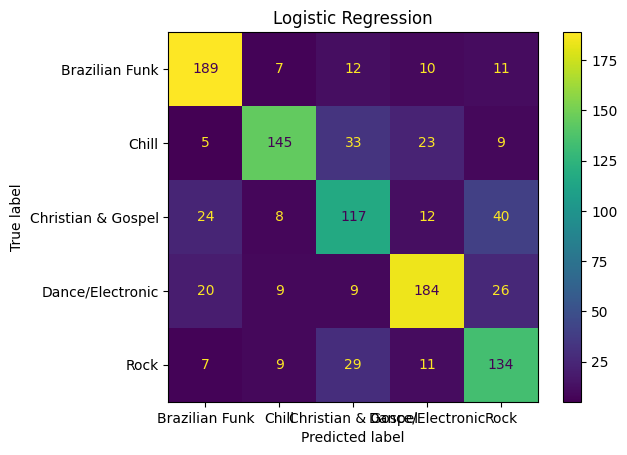

In [35]:
cm = confusion_matrix(y_val, y_val_pred)

# plot confusion matrix of logistic regression
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.title("Logistic Regression")
plt.show()

In [36]:
# AUC
y_val_proba = best_lr_pipeline.predict_proba(X_val)

# roc auc score using one versus rest and macro average
LR_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')
f"The average AUC for the logistic regression model is {LR_auc:0.3f}"

'The average AUC for the logistic regression model is 0.917'

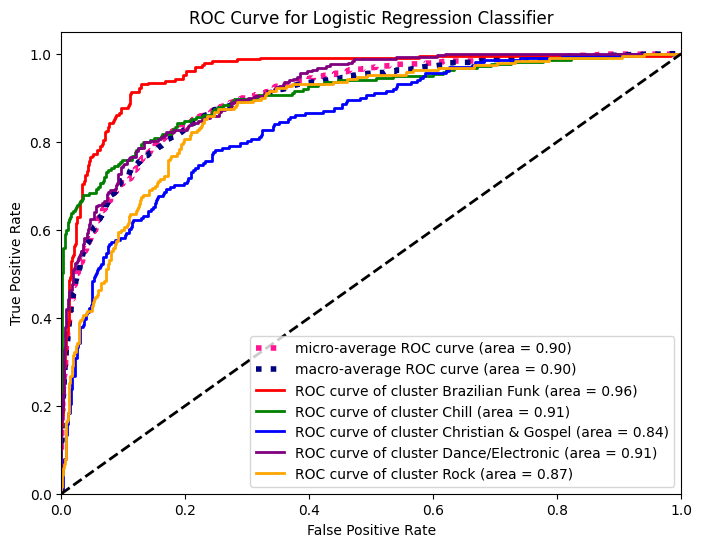

In [37]:
# Plot ROC Curves for Logistic Regression
from sklearn.preprocessing import label_binarize
from itertools import cycle
# Ensure the classes used in label_binarize match the unique classes in y_val
classes = np.unique(y_val)
y_val_bin = label_binarize(y_val, classes=classes)

n_classes = 5
lw=2

y_score = best_lr_pipeline.decision_function(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Change the colors here
colors = cycle(["red", "green", "blue", "purple", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(target_names[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression Classifier")
plt.legend(loc="lower right")
plt.show()

In [38]:
# f1 score
from sklearn.metrics import f1_score
LR_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The baseline F1(macro) socre of the logistic regression model on the validation data is {LR_f1:0.3f}"

'The baseline F1(macro) socre of the logistic regression model on the validation data is 0.705'

### 2. Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline com RandomForestClassifier
pipeline_rf = Pipeline(
    [
        ("scaler", StandardScaler()),  # Escalonar recursos
        ("rf_clf", RandomForestClassifier(random_state=0)),  # Classificador Random Forest
    ]
)

# Defina uma grade de hiperparâmetros para o RandomForestClassifier
param_grid_rf = {
    "rf_clf__n_estimators": [50, 100, 200],              # Número de árvores
    "rf_clf__max_depth": [None, 10, 20, 30],             # Profundidade máxima das árvores
    "rf__min_samples_split": [2, 5, 10],             # Número mínimo de amostras para dividir um nó
    "rf__min_samples_leaf": [1, 2, 4],               # Número mínimo de amostras em uma folha
    "rf__class_weight": [None, "balanced"],          # Ajuste para desbalanceamento
}

# Aplicar o GridSearchCV para o RandomForestClassifier
if False:
    grid_search_rf = GridSearchCV(
        pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    grid_search_rf.fit(X_train, y_train)
    best_lr_pipeline_true=grid_search_rf.best_estimator_

# Ajustar o modelo nos dados de treinamento
# grid_search_rf.fit(X_train, y_train)

# Se você já encontrou os melhores hiperparâmetros, ajuste diretamente o pipeline
best_rf_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                ('rf_clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=200, random_state=0))])
rf_clf=best_rf_pipeline

# Ajustar o pipeline com os dados de treinamento
best_rf_pipeline.fit(X_train, y_train)

# Agora você pode usar best_rf_pipeline para fazer previsões
# Por exemplo:
# y_pred = best_rf_pipeline.predict(X_test)

# Se você precisar visualizar os resultados ou métricas, pode fazer isso aqui


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf_clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=200, random_state=0))])

In [40]:
rf_clf.fit(X_train, y_train)
# make prediction on validation data
y_val_pred = rf_clf.predict(X_val)
# check first 20 ground truths and prediction
print('Actual label:    ', y_val[:5])
print('Predicted label: ', y_val_pred[:5])

Actual label:     ['Dance/Electronic' 'Dance/Electronic' 'Christian & Gospel'
 'Christian & Gospel' 'Brazilian Funk']
Predicted label:  ['Dance/Electronic' 'Dance/Electronic' 'Christian & Gospel'
 'Christian & Gospel' 'Brazilian Funk']


In [41]:
report_2 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_rf = pd.DataFrame(report_2).transpose()
df_r_rf.head()

,precision,recall,f1-score,support
Brazilian Funk,0.832669,0.912664,0.870833,229.0
Chill,0.849515,0.813953,0.831354,215.0
Christian & Gospel,0.766082,0.651741,0.704301,201.0
Dance/Electronic,0.875556,0.794355,0.832981,248.0
Rock,0.673913,0.815789,0.738095,190.0


<Figure size 2000x1200 with 0 Axes>

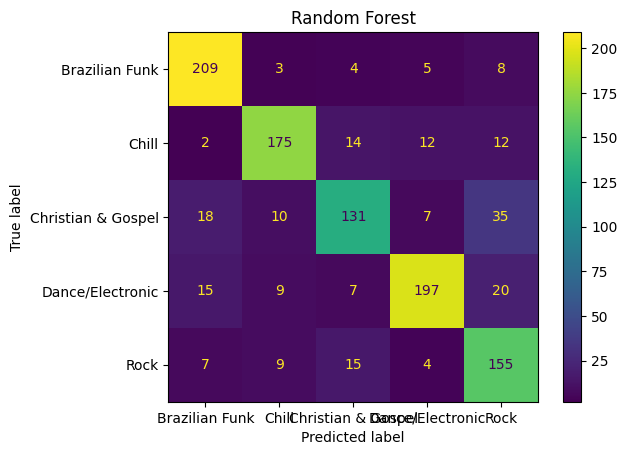

In [42]:
# plot confusion matrix of random forest model
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.title("Random Forest")
plt.show()

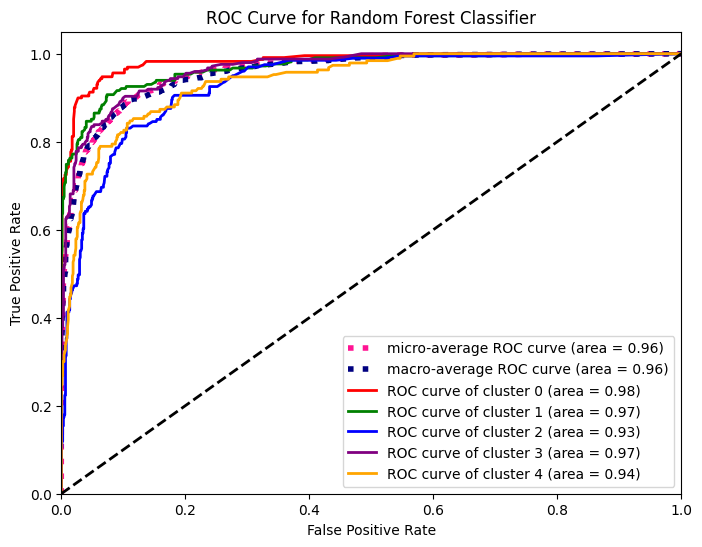

In [43]:
# Plot ROC for Random Forest Classifier
y_score = best_rf_pipeline.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC for a specific class
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["red", "green", "blue", "purple", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest Classifier")
plt.legend(loc="lower right")
plt.show()

In [44]:
RF_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The F1(macro) socre of the random forest model on the validation data is {RF_f1:0.3f}"

'The F1(macro) socre of the random forest model on the validation data is 0.796'

### XGBoost

In [109]:


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Define a pipeline com XGBClassifier
pipeline_xgb = Pipeline(
    [
        ("scaler", StandardScaler()),  # Escalonar recursos
        ("xgb_clf", XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 random_state=0)), 
    ]
)

# Defina uma grade de hiperparâmetros para o XGBClassifier
param_grid_xgb = {
    "xgb_clf__n_estimators": [100, 200,300],
    "xgb_clf__max_depth": [9,11,15],
    "xgb_clf__learning_rate": [0.05, 0.1, 0.2],
    "xgb_clf__subsample": [0.6,0.8, 1.0],
    "xgb_clf__colsample_bytree": [0.8, 1.0],
    "xgb_clf__gamma": [0.5,1.3],
    "xgb_clf__reg_alpha": [0,1,42],  # Regularização L1
    "xgb_clf__reg_lambda":[0.1,0.22760725887771024]
}


# Aplicar o GridSearchCV para o XGBClassifier
if True:
    grid_search_xgb = GridSearchCV(
        pipeline_xgb, param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, error_score='raise'
    )
    grid_search_xgb.fit(X_train, y_train_encoded)
    best_xgb_pipeline = grid_search_xgb.best_estimator_
    print("Best parameters found: ", grid_search_xgb.best_params_)

# Ajustar o modelo nos dados de treinamento
best_xgb_pipeline.fit(X_train, y_train_encoded)

# Agora você pode usar best_xgb_pipeline para fazer previsões
y_val_pred = best_xgb_pipeline.predict(X_val)


Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kali/git/chorano_e_dancando/.venv/

KeyboardInterrupt: 

In [ ]:
xg_clf = best_xgb_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb_clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, nthread=4, num_parallel_tree=None, ...))])

In [95]:
    print("Best parameters found: ", grid_search_xgb.best_params_)


Best parameters found:  {'xgb_clf__colsample_bytree': 1.0, 'xgb_clf__learning_rate': 0.1, 'xgb_clf__max_depth': 6, 'xgb_clf__n_estimators': 200, 'xgb_clf__subsample': 0.8}


In [52]:
from sklearn.preprocessing import LabelEncoder

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Fit the model
xg_clf.fit(X_train, y_train_encoded)

# Make prediction on validation data
y_val_pred_encoded = xg_clf.predict(X_val)

# Decode the predicted labels back to original labels
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Check first 20 ground truths and prediction
print('Actual label:    ', y_val[:10])
print('Predicted label: ', y_val_pred[:10])

/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:08:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Actual label:     ['Dance/Electronic' 'Dance/Electronic' 'Christian & Gospel'
 'Christian & Gospel' 'Brazilian Funk' 'Brazilian Funk'
 'Christian & Gospel' 'Dance/Electronic' 'Christian & Gospel'
 'Dance/Electronic']
Predicted label:  ['Dance/Electronic' 'Dance/Electronic' 'Christian & Gospel'
 'Christian & Gospel' 'Brazilian Funk' 'Brazilian Funk' 'Rock'
 'Dance/Electronic' 'Christian & Gospel' 'Dance/Electronic']


In [58]:
%pip install hyperopt

# import pandas for data wrangling
import pandas as pd


# import numpy for Scientific computations
import numpy as np


# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



Note: you may need to restart the kernel to use updated packages.


In [101]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Define the search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'seed': 0
}



In [107]:
def objective(space):
    clf = xgb.XGBClassifier(
        n_estimators=space['n_estimators'], 
        max_depth=int(space['max_depth']), 
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']), 
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        eval_metric="mlogloss",
        early_stopping_rounds=1000  # Move early_stopping_rounds here
    )
    evaluation = [(X_train, y_train_encoded), (X_val, y_val_encoded)]
    
    clf.fit(X_train, y_train_encoded, 
            eval_set=evaluation, 
            verbose=False)
    
    pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val_encoded, pred)
    print("SCORE:", accuracy)
    
    return {'loss': -accuracy, 'status': STATUS_OK}


In [105]:
from sklearn.preprocessing import LabelEncoder

# Inicialize o LabelEncoder
label_encoder = LabelEncoder()

# Ajuste o LabelEncoder nos dados de treino e transforme os dados de teste
y_test = label_encoder.fit_transform(y_test)

# Verifique os resultados

In [108]:

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)



SCORE:                                                 
0.6971375807940905                                     
SCORE:                                                                            
0.7192982456140351                                                                
SCORE:                                                                            
0.6971375807940905                                                                
SCORE:                                                                            
0.7442289935364728                                                                
SCORE:                                                                            
0.6712834718374885                                                                
SCORE:                                                                            
0.7072945521698984                                                                
SCORE:                                                    

In [99]:
best_hyperparams

{'colsample_bytree': np.float64(0.6520941916373165),
 'gamma': np.float64(1.299478821871946),
 'max_depth': np.float64(15.0),
 'min_child_weight': np.float64(0.0),
 'reg_alpha': np.float64(42.0),
 'reg_lambda': np.float64(0.22760725887771024)}

In [53]:
report_3 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_xgb = pd.DataFrame(report_3).transpose()
df_r_xgb.head()

,precision,recall,f1-score,support
Brazilian Funk,0.876033,0.925764,0.900212,229.0
Chill,0.838095,0.818605,0.828235,215.0
Christian & Gospel,0.759563,0.691542,0.723958,201.0
Dance/Electronic,0.878788,0.818548,0.847599,248.0
Rock,0.682028,0.778947,0.727273,190.0


<Figure size 2000x1200 with 0 Axes>

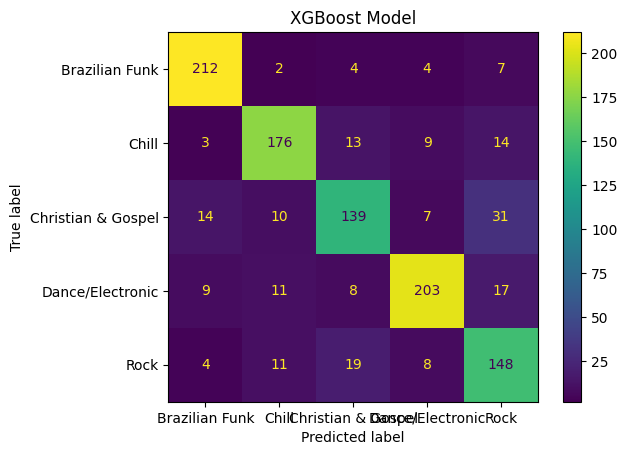

In [54]:
# plot confusion matrix of XGBoost model
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.title("XGBoost Model")
plt.show()

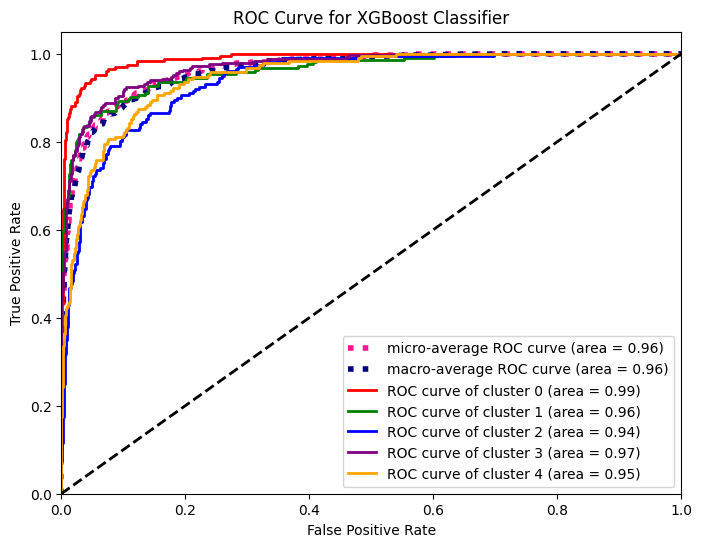

In [55]:
# Plot ROC for Random Forest Classifier
y_score = xg_clf.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC for a specific class
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["red","green","blue","purple","orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Classifier")
plt.legend(loc="lower right")
plt.show()

In [56]:
XG_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The F1(macro) socre of the XGBoost model on the validation data is {XG_f1:0.3f}"

'The F1(macro) socre of the XGBoost model on the validation data is 0.805'

## Conclusion

In [60]:
#XG_f1 RF_f1 LR_f1 compare and take the best one
f1_scores = {
    "Logistic Regression": LR_f1,
    "Random Forest": RF_f1,
    "XGBoost": XG_f1
}

best_model = max(f1_scores, key=f1_scores.get)
best_f1 = f1_scores[best_model]
f"The best model is {best_model} with a F1(macro) score of {best_f1:0.3f}"


'The best model is XGBoost with a F1(macro) score of 0.806'